## fine-tuning

In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9983张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''

import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train3'
valid_data_dir = 'data/validation'
test_data_dir='data/test'

nb_train_samples = 19944
nb_validation_samples = 4986
#batch_size = 277  #19944/277=72  4986/277=18
batch_size = 72   #19944/72=277  4986/72=69.25

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#构造InceptionResNetV2模型

x_input = Input((img_width, img_height, 3))
x_input = Lambda(inception_resnet_v2.preprocess_input)(x_input)

base_model = InceptionResNetV2(input_tensor=x_input, weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False
    
y = Dropout(0.25)(base_model.output)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)

'''
model=build_model(InceptionResNetV2, (img_width, img_height), inception_resnet_v2.preprocess_input)
'''

'\nmodel=build_model(InceptionResNetV2, (img_width, img_height), inception_resnet_v2.preprocess_input)\n'

In [ ]:
# 输出模型结构图
plot_model(model, to_file='model_InceptionResNetV2.png')

In [4]:
#生成训练、验证数据
gen = ImageDataGenerator(rotation_range=40,  #旋转数据增强
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)
val_gen = ImageDataGenerator()
train_generator = gen.flow_from_directory(train_data_dir, (img_height, img_width), shuffle=True, 
                                              batch_size=64,class_mode='binary')
valid_generator = val_gen.flow_from_directory(valid_data_dir, (img_height, img_width), shuffle=True, 
                                              batch_size=32,class_mode='binary')

Found 19944 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.


In [6]:
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(optimizer='adadelta',
model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [10]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 299, 299, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation

Total params: 74,436,865
Trainable params: 54,277,729
Non-trainable params: 20,159,136
__________________________________________________________________________________________________


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [7]:
#训练模型并保存在验证集上损失函数最小的权重
filepath="InceptonResNetV2-fine-tuning.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

epochs = 10

history=model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=nb_validation_samples//batch_size,
    callbacks=callbacks_list)

Epoch 1/10
277/277 [==============================] - 616s 2s/step - loss: 0.5241 - acc: 0.7796 - val_loss: 0.2490 - val_acc: 0.9683

Epoch 00001: val_loss improved from inf to 0.24896, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 2/10
277/277 [==============================] - 526s 2s/step - loss: 0.3050 - acc: 0.9341 - val_loss: 0.1522 - val_acc: 0.9764

Epoch 00002: val_loss improved from 0.24896 to 0.15217, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 3/10
277/277 [==============================] - 528s 2s/step - loss: 0.2262 - acc: 0.9507 - val_loss: 0.1310 - val_acc: 0.9715

Epoch 00003: val_loss improved from 0.15217 to 0.13099, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 4/10
277/277 [==============================] - 528s 2s/step - loss: 0.1872 - acc: 0.9562 - val_loss: 0.1119 - val_acc: 0.9737

Epoch 00004: val_loss improved from 0.13099 to 0.11194, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 5/10
277/277 [==============================] 

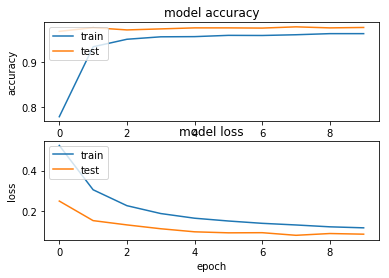

In [8]:
#可视化学习曲线

show_learning_curve(history)


In [10]:
def predict_on_modle(n, width, heigth, test_data_dir, model, weight, output_name):
    x_test = np.zeros((n,width,heigth,3),dtype=np.uint8)

    for i in tqdm(range(n)):
    #for i in range(n):
        img = load_img(test_data_dir+"/test/"+'/%d.jpg' % (i+1)) 
        x_test[i,:,:,:] = img_to_array(img.resize((width,heigth),Image.ANTIALIAS))
    
#     x_test = xception.preprocess_input(x_test)
    model.load_weights(weight)
    y_test = model.predict(x_test, verbose=1)
    y_test = y_test.clip(min=0.005, max=0.995)
    
    df = pd.read_csv("sample_submission.csv")
    for i in tqdm(range(n)):
        df.set_value(i, 'label', y_test[i])
    df.to_csv(output_name, index=None)
    df.head(10)

In [11]:
#预测结果   
predict_on_modle(12500, img_height, img_width, test_data_dir, model, filepath, "pred-InceptonResNetV2-fine-tuning.csv")

100%|██████████| 12500/12500 [02:45<00:00, 75.44it/s]


12500/12500 [==============================] - 392s 31ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
100%|██████████| 12500/12500 [00:00<00:00, 149553.87it/s]


## 冻结前698层，再训练
放开Inception-resnet-C第5个block之后的层，不含Inception-resnet-C_5  
698 block8_5_ac 

In [ ]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=698)

In [ ]:
model.load_weights('InceptonResNetV2-fine-tuning.h5')

model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#训练模型并保存在验证集上损失函数最小的权重
filepath="InceptonResNetV2-fine-tuning-698.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=5, 
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)

In [ ]:
#可视化学习曲线
show_learning_curve(history)

In [ ]:
#预测结果
predict_on_model(12500, 299, 299, test_data_dir, model, "InceptonResNetV2-fine-tuning-698.h5", "pred-InceptonResNetV2-fine-tuning-698.csv")

## 冻结前618层，再训练
放开Reduction-B之后的层，不含Reduction-B  
618 mixed_7a

In [ ]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=618)

In [ ]:
model.load_weights('InceptonResNetV2-fine-tuning.h5')

model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#训练模型并保存在验证集上损失函数最小的权重
filepath="InceptonResNetV2-fine-tuning-1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=5, 
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)

In [ ]:
#预测结果
predict_on_model(12500, 299, 299, test_data_dir, model, "InceptonResNetV2-fine-tuning-618.h5", "pred-InceptonResNetV2-fine-tuning-618.csv")

## 冻结前499层，再训练
放开Inception-resnet-B 第17个block之后的层，不含包Inception-resnet-B_17  
499 block17_14_ac

In [ ]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=499)

In [ ]:
model.load_weights('InceptonResNetV2-fine-tuning.h5')

model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#训练模型并保存在验证集上损失函数最小的权重
filepath="InceptonResNetV2-fine-tuning-1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=5, 
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)


In [ ]:
#预测结果
predict_on_model(12500, 299, 299, test_data_dir, model, "InceptonResNetV2-fine-tuning-499.h5", "pred-InceptonResNetV2-fine-tuning-499.csv")